In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')

import plotly.express as px

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots
import gc
import joblib
import os
import pickle

In [2]:
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm

## 6. Modeling and Prediction

In [3]:
for _ in tqdm(range(1)):
    data = pd.read_csv('Input/data_sam.csv',index_col = [])

In [4]:
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [5]:

sales = pd.read_csv('Input/sell_prices.csv')

In [6]:
sales.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
sales.store_id = sales.store_id.astype('category')

In [8]:
%%time
Temp_data = sales.store_id.astype('category')
d_store_id = dict(zip(Temp_data.cat.codes,sales.store_id))

Wall time: 1.74 s


In [13]:
X_train

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
6,21101245,5530,553,1,0,0,0,693,11247,0,...,0.9950,0.6800,0.9850,0.9850,1.305,1.932,1.1480,NaN,NaN,-0.7600
12,14820003,2510,251,1,0,0,0,487,11218,5,...,0.9950,2.6250,2.0500,2.0500,1.305,1.932,1.1480,NaN,NaN,-2.5250
13,38052744,26610,2661,6,2,0,0,1249,11422,1,...,0.3003,0.6377,0.3079,0.3079,1.305,0.716,0.3452,NaN,NaN,-0.5815
23,2257293,24700,2470,5,2,0,0,75,11111,6,...,1.1190,1.4930,1.7880,1.7880,1.305,0.716,1.0750,NaN,NaN,-0.5340
26,15034527,13450,1345,2,0,0,0,494,11219,5,...,2.0350,0.2183,0.1986,0.1986,1.305,1.932,2.4600,NaN,NaN,-0.2240


In [9]:
d_store_id

{0: 'CA_1',
 1: 'CA_2',
 2: 'CA_3',
 3: 'CA_4',
 4: 'TX_1',
 5: 'TX_2',
 6: 'TX_3',
 7: 'WI_1',
 8: 'WI_2',
 9: 'WI_3'}

In [14]:
X_train.head()

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
6,21101245,5530,553,1,0,0,0,693,11247,0,...,0.9950,0.6800,0.9850,0.9850,1.305,1.932,1.1480,NaN,NaN,-0.7600
12,14820003,2510,251,1,0,0,0,487,11218,5,...,0.9950,2.6250,2.0500,2.0500,1.305,1.932,1.1480,NaN,NaN,-2.5250
13,38052744,26610,2661,6,2,0,0,1249,11422,1,...,0.3003,0.6377,0.3079,0.3079,1.305,0.716,0.3452,NaN,NaN,-0.5815
23,2257293,24700,2470,5,2,0,0,75,11111,6,...,1.1190,1.4930,1.7880,1.7880,1.305,0.716,1.0750,NaN,NaN,-0.5340
26,15034527,13450,1345,2,0,0,0,494,11219,5,...,2.0350,0.2183,0.1986,0.1986,1.305,1.932,2.4600,NaN,NaN,-0.2240


In [17]:
X_valid

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
136,58360032,5600,560,1,0,0,0,1915,11613,5,...,0.9950,1.4120,1.0750,1.0750,1.305,1.932,1.1480,NaN,NaN,4.49000
178,58876960,22070,2207,5,2,0,0,1932,11615,0,...,1.1190,0.1111,0.3640,0.3640,1.305,0.716,1.0750,NaN,NaN,-0.12036
906,58421559,11070,1107,2,0,0,0,1917,11613,4,...,2.0350,0.4836,1.6480,1.6480,1.305,1.932,2.4600,NaN,NaN,-0.50340
1871,58694315,25020,2502,5,2,0,0,1926,11615,2,...,1.1190,1.2930,1.1860,1.1860,1.305,0.716,1.0750,NaN,NaN,-1.18400
2098,58726165,8130,813,2,0,0,0,1927,11615,3,...,2.0350,2.6250,2.3670,2.3670,1.305,1.932,2.4600,NaN,NaN,-0.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17687548,58664988,6160,616,2,0,0,0,1925,11614,0,...,2.0350,0.1781,0.1569,0.1569,1.305,1.932,2.4600,0.1428,0.1781,-0.18790
17687688,58847137,28740,2874,6,2,0,0,1931,11615,4,...,0.3003,0.3710,1.0630,1.0630,1.305,0.716,0.3452,0.1428,0.3710,-0.34940
17689397,58878840,10380,1038,2,0,0,0,1932,11615,0,...,2.0350,0.4810,0.4565,0.4565,1.305,1.932,2.4600,0.2856,0.4810,-0.48600
17689837,59062160,14180,1418,2,0,0,0,1938,11616,4,...,2.0350,2.7830,3.4430,3.4430,1.305,1.932,2.4600,3.1430,2.7830,-1.76600


In [16]:
X_test

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
682,59273166,20430,2043,5,2,0,0,1945,11617,4,...,1.1190,0.1537,0.19430,0.19430,1.305,0.716,1.0750,NaN,0.0000,-0.1787
1872,60006168,2360,236,1,0,0,0,1969,11621,3,...,0.9950,6.2270,6.03500,6.03500,1.305,1.932,1.1480,NaN,NaN,-6.3670
3019,59395098,20150,2015,5,2,0,0,1949,11618,1,...,1.1190,0.4778,0.53200,0.53200,1.305,0.716,1.0750,NaN,NaN,-0.4927
3386,59395306,22230,2223,5,2,0,0,1949,11618,1,...,1.1190,0.7314,0.66650,0.66650,1.305,0.716,1.0750,NaN,1.5000,-0.7754
4953,59212576,24330,2433,5,2,0,0,1943,11617,5,...,1.1190,0.7344,2.12000,2.12000,1.305,0.716,1.0750,NaN,NaN,-0.7060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17686005,59640997,9450,945,2,0,0,0,1957,11619,5,...,2.0350,0.6436,1.02800,1.02800,1.305,1.932,2.4600,0.1428,0.6436,-0.6930
17687675,59883043,21200,2120,5,2,0,0,1965,11620,6,...,1.1190,0.3606,0.42870,0.42870,1.305,0.716,1.0750,0.8570,0.3606,-0.3748
17687741,59518007,29640,2964,6,2,0,0,1953,11618,0,...,0.3003,0.0743,0.08405,0.08405,1.305,0.716,0.3452,0.0000,0.0743,-0.1097
17688810,59761064,21010,2101,5,2,0,0,1961,11620,2,...,1.1190,0.9077,1.07500,1.07500,1.305,0.716,1.0750,0.5713,0.9077,-0.9214


In [19]:
%%time

# Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id'] == store]
    
    # Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis = 1) , df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis = 1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis = 1)
    X_train = X_train.iloc[:,1:]
    X_valid = X_valid.iloc[:,1:]
    X_test = X_test.iloc[:,1:]
    # Train and Validate

    model = LGBMRegressor(
        n_estimators = 1000,
        learning_rate = 0.3,
        subsample = 0.8,
        colsample_bytree = 0.8,
        max_depth = 8,
        num_leaves = 50,
        min_child_weight =300
    
    )
    
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    
    model.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_valid,y_valid)],eval_metric = 'rmse',verbose = 20,
             early_stopping_rounds = 20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model' + str(d_store_id[store]) +'pkl'
    
    # save model
    joblib.dump(model,filename)
    del model,X_train, y_train,  X_valid,y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.755796	training's l2: 0.571227	valid_1's rmse: 0.460094	valid_1's l2: 0.211687
[40]	training's rmse: 0.703344	training's l2: 0.494693	valid_1's rmse: 0.416138	valid_1's l2: 0.173171
[60]	training's rmse: 0.678239	training's l2: 0.460009	valid_1's rmse: 0.404625	valid_1's l2: 0.163721
[80]	training's rmse: 0.656198	training's l2: 0.430595	valid_1's rmse: 0.391331	valid_1's l2: 0.15314
[100]	training's rmse: 0.643519	training's l2: 0.414117	valid_1's rmse: 0.379125	valid_1's l2: 0.143736
[120]	training's rmse: 0.631718	training's l2: 0.399068	valid_1's rmse: 0.375844	valid_1's l2: 0.141259
[140]	training's rmse: 0.619773	training's l2: 0.384119	valid_1's rmse: 0.371645	valid_1's l2: 0.13812
[160]	training's rmse: 0.610245	training's l2: 0.372399	valid_1's rmse: 0.36658	valid_1's l2: 0.134381
[180]	training's rmse: 0.602542	training's l2: 0.363056	valid_1's rmse: 0.366

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



*****Prediction for Store: CA_2*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.366627	training's l2: 0.134415	valid_1's rmse: 0.462672	valid_1's l2: 0.214066
[40]	training's rmse: 0.319144	training's l2: 0.101853	valid_1's rmse: 0.42465	valid_1's l2: 0.180328
[60]	training's rmse: 0.293473	training's l2: 0.0861266	valid_1's rmse: 0.413496	valid_1's l2: 0.170979
[80]	training's rmse: 0.275786	training's l2: 0.0760581	valid_1's rmse: 0.401804	valid_1's l2: 0.161446
[100]	training's rmse: 0.265299	training's l2: 0.0703834	valid_1's rmse: 0.401793	valid_1's l2: 0.161437
[120]	training's rmse: 0.255162	training's l2: 0.0651074	valid_1's rmse: 0.398819	valid_1's l2: 0.159056
[140]	training's rmse: 0.246786	training's l2: 0.0609034	valid_1's rmse: 0.395593	valid_1's l2: 0.156494
Early stopping, best iteration is:
[130]	training's rmse: 0.2507	training's l2: 0.0628504	valid_1's rmse: 0.393282	valid_1's l2: 0.154671
*****Prediction for Store: CA_3*****

[180]	training's rmse: 0.329604	training's l2: 0.108639	valid_1's rmse: 0.659312	valid_1's l2: 0.434693
[200]	training's rmse: 0.319393	training's l2: 0.102012	valid_1's rmse: 0.64744	valid_1's l2: 0.419178
[220]	training's rmse: 0.31214	training's l2: 0.0974314	valid_1's rmse: 0.635728	valid_1's l2: 0.40415
[240]	training's rmse: 0.305679	training's l2: 0.0934397	valid_1's rmse: 0.628689	valid_1's l2: 0.39525
[260]	training's rmse: 0.300375	training's l2: 0.0902252	valid_1's rmse: 0.62189	valid_1's l2: 0.386748
[280]	training's rmse: 0.29549	training's l2: 0.0873146	valid_1's rmse: 0.614624	valid_1's l2: 0.377763
[300]	training's rmse: 0.291808	training's l2: 0.0851517	valid_1's rmse: 0.607349	valid_1's l2: 0.368873
[320]	training's rmse: 0.286602	training's l2: 0.0821406	valid_1's rmse: 0.602423	valid_1's l2: 0.362913
[340]	training's rmse: 0.282244	training's l2: 0.0796615	valid_1's rmse: 0.599487	valid_1's l2: 0.359384
[360]	training's rmse: 0.278705	training's l2: 0.0776767	valid_

##### plotting feature importances

In [29]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
features = features[1:]

In [30]:
for filename in os.listdir('model/'):
    if 'model' in filename:
        # load model
        model = joblib.load('model/'+filename)
        store_importance_df = pd.DataFrame()
        store_importance_df['feature'] = features
        store_importance_df['importance'] = model.feature_importances_
        store_importance_df['store'] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df,store_importance_df],axis = 0)
        


In [31]:
A = pd.DataFrame(np.array([1,2,3,4,5,6]).reshape(3,2),columns =['a','b'])

In [38]:
A[A.isin([1,2,3])]

,a,b
0,1.0,2.0
1,3.0,NaN
2,NaN,NaN


In [53]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    #print(cols)
    print(best_features)
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()

                feature  importance store
0                    id         348  CA_1
1               item_id          64  CA_1
6                     d         249  CA_1
7              wm_yr_wk         139  CA_1
8               weekday          88  CA_1
..                  ...         ...   ...
28    cat_item_sold_avg          51  WI_3
29   dept_item_sold_avg          13  WI_3
33    rolling_sold_mean        1251  WI_3
34  expanding_sold_mean         212  WI_3
35        selling_trend         819  WI_3

[200 rows x 3 columns]


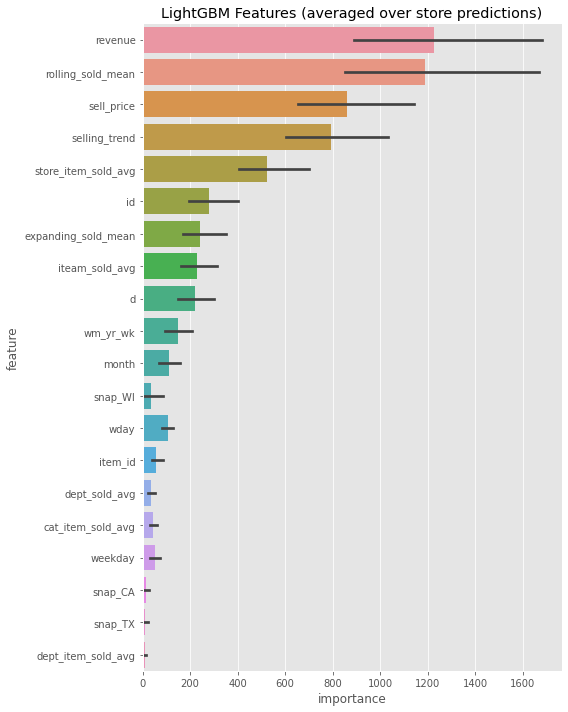

In [54]:
display_importances(feature_importance_df)